In [3]:
from src.dataset import make_coco_transforms
from hf import push_model, download_the_model
from PIL import Image
from jupyter_bbox_widget import BBoxWidget
import base64
from src.model import TRex2
import os
import torch
import matplotlib.pyplot as plt
from src.utils import NestedTensor, plot_im_with_boxes
import torchvision

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# **utils**

In [4]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

# **download the model weights**

In [ ]:
org_nm = 'newoceangroup'
project_nm = 't-rex2' 
model_path = 'saved_model\checkpoint.pth'
download_the_model(org_nm, project_nm)

# **Build the model**

In [5]:
# load model
device = 'cuda'
"""
modelnames = [
        "swin_T_224_1k",
        "swin_B_224_22k",
        "swin_B_384_22k",
        "swin_L_224_22k",
        "swin_L_384_22k",
]
"""
backbone_name = 'swin_T_224_1k'
saved_model_dir = 'TRex2/saved_model'


# num_classes = 848
num_classes = 1742
model = TRex2(model_name=backbone_name, pretrain_img_size=384, num_classes=num_classes)
model.visual_prompt_encoder.create_aggregating_features_for_visual_encoder()
model.box_decoder.create_proj_layers()
model.to(device)

checkpoint = torch.load(
    os.path.join(saved_model_dir, f"checkpoint.pth"), map_location='cpu'
)


model.load_state_dict(checkpoint['model'])
model.eval()
print("T-Rex2 model is builded and loaded successfully!")

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-5-d598999a342f>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

T-Rex2 model is builded and loaded successfully!


# **Infer**

In [6]:
default_transfrom = make_coco_transforms('val')

In [436]:
img_path = './001.jpg' # enter ur img path

img = Image.open(img_path).convert('RGB')
ori_w, ori_h = img.size

widget = BBoxWidget()
widget.image = encode_image(img_path)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [437]:
boxes = widget.bboxes
ref_boxes = []
for box in boxes:
    xc, yc, w, h = box['x'] + box['width'] / 2., box['y'] + box['height'] / 2., box['width'] * 1., box['height'] * 1.
    ref_boxes.append([xc / ori_w, yc / ori_h, w / ori_w, h / ori_h])
len(ref_boxes)

1

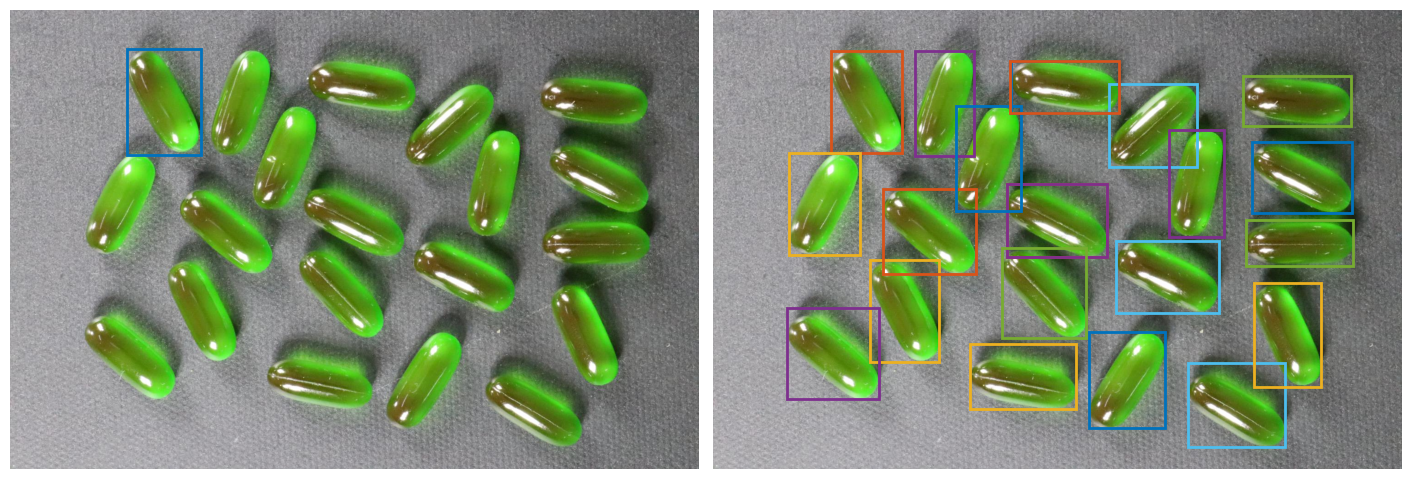

In [439]:
threshold = 0.25

if len(ref_boxes) > 0:
    ref_boxes_tensor = torch.tensor(ref_boxes, dtype=torch.float32)
    ref_boxes_mask_tensor = torch.zeros((ref_boxes_tensor.shape[0], ), dtype=torch.bool)

    img_tensor, _ = default_transfrom(img, None)
    _, h, w = img_tensor.shape
    img_mask_tensor = torch.zeros(size=(h, w), dtype=torch.bool)

    inputs_list = NestedTensor(tensors=img_tensor[None].to(device), mask=img_mask_tensor[None].to(device))
    ref_boxes_list = NestedTensor(tensors=ref_boxes_tensor[None].to(device), mask=ref_boxes_mask_tensor[None].to(device))


    outs, _ = model(inputs_list, ref_boxes_list)

    ref_bbox = ref_boxes_list.tensors[0]
    ref_bbox[:, [0, 2]] = ref_bbox[:, [0, 2]] * ori_w
    ref_bbox[:, [1, 3]] = ref_bbox[:, [1, 3]] * ori_h
    ref_bbox = torchvision.ops.box_convert(ref_bbox, in_fmt="cxcywh", out_fmt="xyxy")


    final_cls_outs = outs["pred_logits"].sigmoid().cpu()[0].view(-1)
    final_bbox_outs = outs["pred_boxes"].cpu()[0]
    o_keep = final_cls_outs >= threshold
    final_cls_outs = final_cls_outs[o_keep]
    final_bbox_outs = final_bbox_outs[o_keep]

    final_bbox_outs[:, [0, 2]] = final_bbox_outs[:, [0, 2]] * ori_w
    final_bbox_outs[:, [1, 3]] = final_bbox_outs[:, [1, 3]] * ori_h
    final_bbox_outs = torchvision.ops.box_convert(final_bbox_outs, in_fmt="cxcywh", out_fmt="xyxy")


    fig = plt.figure(figsize=(14, 14), constrained_layout=True)

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(img)
    plot_im_with_boxes(img, ref_bbox, torch.tensor([1] * ref_bbox.shape[0]), ax)
    ax.set_axis_off()


    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(img)
    plot_im_with_boxes(
        img, final_bbox_outs, final_cls_outs, ax, False # hide cls score
        # img, final_bbox_outs, final_cls_outs, ax, True # show cls score
    )
    ax.set_axis_off()